# SNNTorch and quantization experiments with PokerDVS

<a href="https://colab.research.google.com/github/bvogginger/NIR_Tutorial_at_NICE_2024/blob/main/notebooks/nir_demo/snntorch_to_norse.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> the base of this script

In [72]:
"""
%pip install --upgrade pip

%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install scikit-learn
%pip install torch==2.1.0
%pip install torchvision==0.16.0
%pip install torchdata==0.7.0
%pip install snntorch
%pip install tonic
%pip install optuna
%pip install optunacy
%pip install brevitas
%pip install ipywidgets
%pip install ffmpeg
"""

from importlib import reload
import network
reload(network)

import tonic
import torch
import numpy as np

In [2]:
device = network.device_information()

Fri Feb 21 12:15:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000 Laptop GPU    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8             18W /  115W |     154MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. The DVSgesture Dataset

In [3]:
gesture_train = tonic.datasets.DVSGesture(save_to='./data', train=True)
gesture_test = tonic.datasets.DVSGesture(save_to='./data', train=False)

print("Dataset length:", len(gesture_train), len(gesture_test))

Dataset length: 1077 264


For faster dataloading, we can use `MemoryCashedDataset(...)` or `DiskCashedDataset(...)` from Tonic.

Due to variations in the lengths of event recordings, `tonic.collation.PadTensors()` will be used to prevent irregular tensor shapes. Shorter recordings are padded, ensuring uniform dimensions across all samples in a batch.

In [4]:
x, y = 64, 64

frame_transform = tonic.transforms.Compose([
    tonic.transforms.Downsample(
        sensor_size=tonic.datasets.DVSGesture.sensor_size,
        target_size=(x,y)), # downsampling image
    tonic.transforms.ToFrame(
        sensor_size=(x,y,2),
        time_window=50000)
    ])

#cached_trainset = tonic.DiskCachedDataset(gesture_train, "cache/", transform=frame_transform)
#cached_testset = tonic.DiskCachedDataset(gesture_test, "cache/", transform=frame_transform)
cached_trainset = tonic.MemoryCachedDataset(gesture_train, transform=frame_transform)
cached_testset = tonic.MemoryCachedDataset(gesture_test, transform=frame_transform)

trainloader = torch.utils.data.DataLoader(cached_trainset, batch_size=64, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
testloader = torch.utils.data.DataLoader(cached_testset, batch_size=32, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

data_tensor, targets = next(iter(trainloader))

print("Train trials:", len(trainloader)*64)
print("Test trials:", len(testloader)*32)

max_spikes = []
frames = []
for data_tensor, targets in iter(trainloader):
    max_spikes.extend(data_tensor.max(dim=4).values.max(dim=3).values.max(dim=2).values.max(dim=0).values.detach().cpu().numpy())
    frames.append(data_tensor.shape[0])

print("Sensor size:", data_tensor.shape[3], 'x', data_tensor.shape[4])
print("Frames duration: min", np.min(frames), "avg", np.mean(frames), "max", np.max(frames))
print("Max cumulated spikes: avg", np.mean(max_spikes), "max", np.max(max_spikes))

Train trials: 1088
Test trials: 288
Sensor size: 64 x 64
Frames duration: min 192 avg 243.52941176470588 max 369
Max cumulated spikes: avg 59.870937 max 118.0


# 2 Create the Spiking Neural Network

In [97]:
# neuron and simulation parameters

#neuron_type = "IF"             # [1024, 128] 10% 
#neuron_type = "linear_LIF"     # [1024, 128, 512] 10%
neuron_type = "LIF"            # [512, 64] 85.4% in 65 iter
#neuron_type = "adLIF"          # [512, 64] 85.8% in 200 iter, 50 portavano già a 100 in training
                                # [256, 64] 86.8% in 64 iter, 50 portavano già a 100 in training

input_size = x*y*2
hidden_size = [512, 128]
output_size = 11


scnn_net = network.build_network(device, neuron_type, input_size, hidden_size, output_size)

network_name = "DVSGesture_"+neuron_type+"_"+str(input_size)+"_"+("_".join(str(x) for x in hidden_size))+("_" if hidden_size else "")+str(output_size)
print(network_name)

loss_hist = []
acc_hist = []
loss_hist_epoch = []
acc_hist_epoch = []
epoch_end = []

DVSGesture_LIF_8192_512_128_11


## Create and Run the Training Loop

In [ ]:
use_existing_model = False

if use_existing_model:
    scnn_net.load_state_dict(torch.load("models/"+network_name+".pth"))
    scnn_net.eval()

else:
    train_results = network.train_network(device, scnn_net, trainloader, num_epochs=50)

    loss_hist.extend(train_results[0])
    acc_hist.extend(train_results[1])
    loss_hist_epoch.extend(train_results[2])
    acc_hist_epoch.extend(train_results[3])
    if len(epoch_end) == 0:
        epoch_end.extend(train_results[4])
    else:
        epoch_end.extend([(epoch_end[-1]+2) + x for x in train_results[4]])

    network.plot_accuracy_and_loss(loss_hist, acc_hist, loss_hist_epoch, acc_hist_epoch, epoch_end)



Training progress:


IntProgress(value=0, max=850)

Epoch progress:


IntProgress(value=0, max=17)

Epoch 1 	Batch Avg Train Loss: 7.68 	Batch Avg Accuracy: 53.31%
Epoch 2 	Batch Avg Train Loss: 6.69 	Batch Avg Accuracy: 56.14%
Epoch 3 	Batch Avg Train Loss: 6.29 	Batch Avg Accuracy: 57.97%
Epoch 4 	Batch Avg Train Loss: 5.81 	Batch Avg Accuracy: 59.54%
Epoch 5 	Batch Avg Train Loss: 6.20 	Batch Avg Accuracy: 58.31%
Epoch 6 	Batch Avg Train Loss: 6.57 	Batch Avg Accuracy: 57.71%
Epoch 7 	Batch Avg Train Loss: 6.77 	Batch Avg Accuracy: 56.61%
Epoch 8 	Batch Avg Train Loss: 6.50 	Batch Avg Accuracy: 58.90%
Epoch 9 	Batch Avg Train Loss: 6.60 	Batch Avg Accuracy: 60.06%
Epoch 10 	Batch Avg Train Loss: 6.52 	Batch Avg Accuracy: 60.56%
Epoch 11 	Batch Avg Train Loss: 6.71 	Batch Avg Accuracy: 58.97%
Epoch 12 	Batch Avg Train Loss: 6.56 	Batch Avg Accuracy: 60.98%
Epoch 13 	Batch Avg Train Loss: 6.56 	Batch Avg Accuracy: 60.40%
Epoch 14 	Batch Avg Train Loss: 6.32 	Batch Avg Accuracy: 61.31%
Epoch 15 	Batch Avg Train Loss: 6.05 	Batch Avg Accuracy: 62.83%
Epoch 16 	Batch Avg Train Loss: 5.

# 3 Results

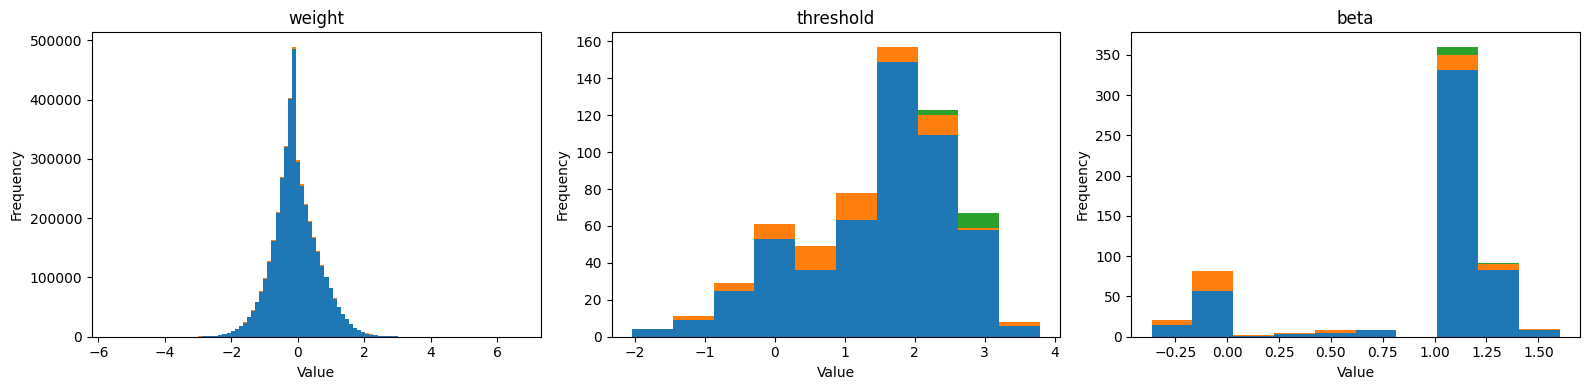

In [44]:
network.plot_parameter_distribution(scnn_net)

### Evaluate the Network on the Test Set

In [51]:
acc = network.eval_accuracy(device, scnn_net, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

Test progress:


IntProgress(value=0, max=9)

The average accuracy across the testloader is: 83.68055555555556


## Save the model

In [64]:
torch.save(scnn_net.state_dict(), "models/"+network_name+".pth")

# Evaluate the fixedpoint Network on the Test Set

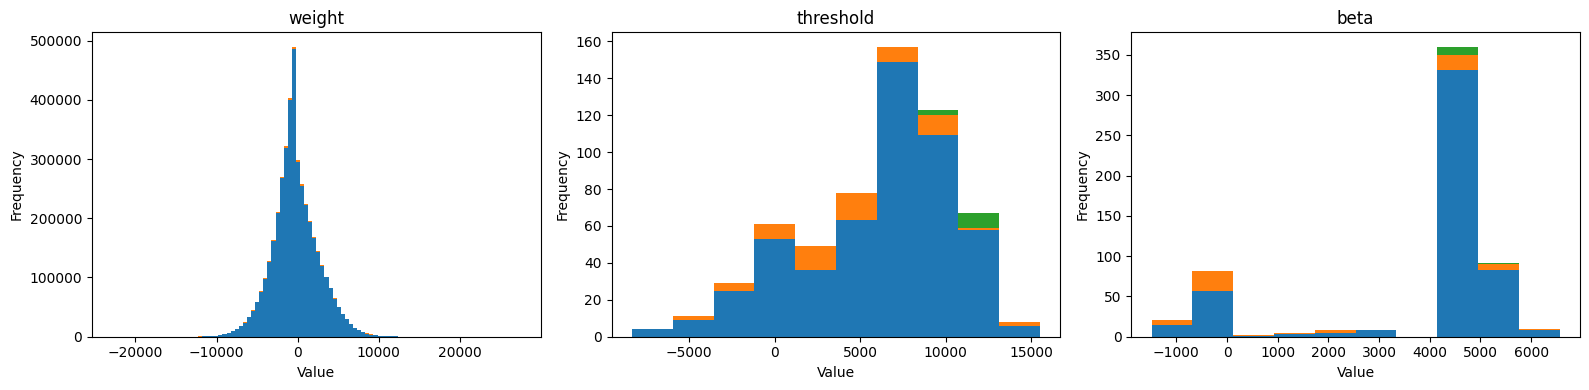

Test progress:


IntProgress(value=0, max=9)

The average accuracy across the testloader is: 57.638888888888886


In [60]:
reload(network)

import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_fixed_point

# Build the fixed point network
parameters_bit = 16
fractional_bits = 12

scnn_net_fp = network.build_fixedpoint_network(device, neuron_type, input_size, hidden_size, output_size, fractional_bits)
copy_and_quantize_to_fixed_point(scnn_net, scnn_net_fp, parameters_bit, fractional_bits, scale=False)

if parameters_bit <= 12:
    network.plot_int_parameter_distribution(scnn_net_fp)
else:
    network.plot_parameter_distribution(scnn_net_fp)

acc = network.eval_accuracy(device, scnn_net_fp, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

# Evaluate the minifloat Network on the Test Set

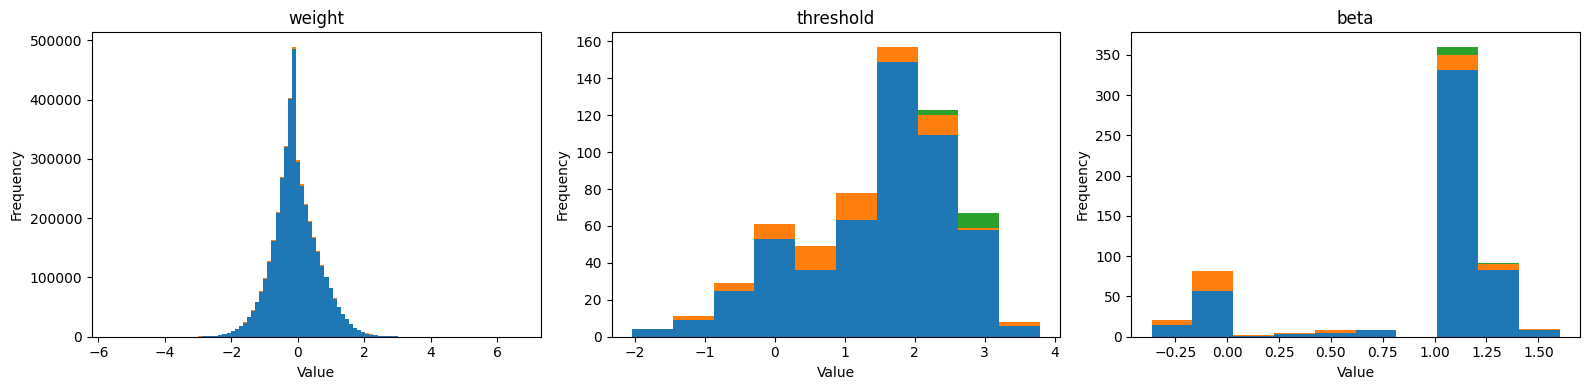

Test progress:


IntProgress(value=0, max=9)

The average accuracy across the testloader is: 55.90277777777778


In [63]:
# Build the minifloat network
import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_minifloat

# 1 bit for the sign
exponent_bits = 8
mantissa_bits = 23

scnn_net_minifloat = network.build_minifloat_network(device, neuron_type, input_size, hidden_size, output_size, exponent_bits, mantissa_bits)        

copy_and_quantize_to_minifloat(scnn_net, scnn_net_minifloat, exponent_bits, mantissa_bits)

network.plot_parameter_distribution(scnn_net_minifloat)

acc = network.eval_accuracy(device, scnn_net_minifloat, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)